## Fine-tuning a model

#### loading a pre-trained model

In [1]:
from transformers import AutoModelForSequenceClassification
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import os
import pandas as pd

pd.set_option("display.max_colwidth", None)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
emotions = load_dataset('emotion')

In [37]:
labels = emotions['train'].features['label'].names

In [3]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [47]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [32]:
y_valid = np.array(emotions_encoded['validation']['label'])

In [6]:
num_labels = 6
model = (
    AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device)
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.

#### defining performance metrics

In [8]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    reca = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1, "recall": reca}

#### Training a model

In [10]:
## log in on the Hugging Face hub, to push the model and define hyperparameters
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [12]:
from transformers import Trainer, TrainingArguments

In [13]:
batch_size = 64
logging_steeps = len(emotions_encoded["train"]) // batch_size

model_name = f"{model_ckpt}-fine-tuned-emotion"

training_args = TrainingArguments(
    optim='adamw_torch', # supress the warning error
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steeps,
    push_to_hub=True,
    log_level="error"
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

Cloning https://huggingface.co/juanxo90/distilbert-base-uncased-fine-tuned-emotion into local empty directory.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.783800,0.299546,0.906000,0.903884,0.906000
2,0.237000,0.215609,0.925500,0.925414,0.925500


TrainOutput(global_step=500, training_loss=0.5104204940795899, metrics={'train_runtime': 634.0657, 'train_samples_per_second': 50.468, 'train_steps_per_second': 0.789, 'total_flos': 720342861696000.0, 'train_loss': 0.5104204940795899, 'epoch': 2.0})

In [15]:
## generating the confusion matrix for our classifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("normalized confusion matrix")
    plt.show()

In [17]:
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output.metrics

{'test_loss': 0.21560880541801453,
 'test_accuracy': 0.9255,
 'test_f1': 0.9254141326182981,
 'test_recall': 0.9255,
 'test_runtime': 12.8528,
 'test_samples_per_second': 155.608,
 'test_steps_per_second': 2.49}

In [30]:
y_preds = np.argmax(pred_output.predictions, axis=1)
## also you can use pred_output.predictions.argmax(-1)

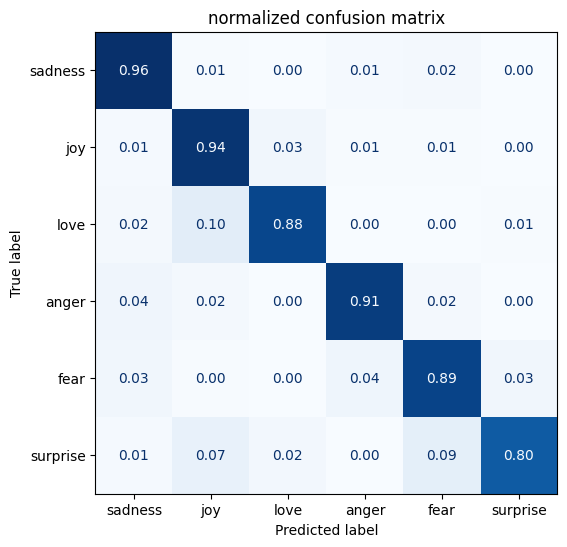

In [43]:
## important note! you can get the labels from the validation set using the
# labels or also you can get it from the predictions instance variable like
# prediction_class.label_ids

plot_confusion_matrix(y_preds, y_valid, labels)
# plot_confusion_matrix(y_preds, pred_output.label_ids)

#### error analysis

In [44]:
## passing the validation samplig by the loss model analyze model prediction
from torch.nn.functional import cross_entropy

In [45]:
def forward_pass_with_label(batch):
    # place all the input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(
            output.logits, batch["label"].to(device), reduction="none"
        )
    # place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}


In [46]:
## getting losses for all the samples

## convert to tensor
emotions_encoded.set_format(
    "torch", columns=["input_ids", "attention_mask", "label"]
)

## compute loss
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [48]:
## creating DF with text, losses, predict label and true label
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [53]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.941275
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,5.746539
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.499767
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,5.322092
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,love,sadness,5.272374
1801,i feel that he was being overshadowed by the supporting characters,love,sadness,5.045741
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,5.038470
318,i felt ashamed of these feelings and was scared because i knew that something wrong with me and thought i might be gay,fear,sadness,4.791255
1509,i guess this is a memoir so it feels like that should be fine too except i dont know something about such a deep amount of self absorption made me feel uncomfortable,joy,fear,4.615205
1590,deception from a person i loved very much,anger,love,4.603844


In [54]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1140,i do think about certain people i feel a bit disheartened about how things have turned out between them it all seems shallow and really just plain bitchy,sadness,sadness,0.014981
133,i and feel quite ungrateful for it but i m looking forward to summer and warmth and light nights,sadness,sadness,0.014982
1531,i forgive stanley hes not so quick to forgive as well and accuses me of making a foolish mistake and making him feel unwelcome in our apt,sadness,sadness,0.015003
189,i leave the meeting feeling more than a little disheartened,sadness,sadness,0.015076
1601,i feel so ungrateful when thinking saying these things but im not sure how to make myself better,sadness,sadness,0.015107
1656,im feeling very jaded and uncertain about love and all basically im sick of being the one more in love of falling for someone who doesnt feel as much towards me,sadness,sadness,0.015117
1466,i feel so ungrateful to be wishing this pregnancy over now,sadness,sadness,0.015155
1041,i suppose it all goes along with feeling unwelcome and mostly being shunned,sadness,sadness,0.015258
244,im kinda relieve but at the same time i feel disheartened,sadness,sadness,0.015270
1368,i started this blog with pure intentions i must confess to starting to feel a little disheartened lately by the knowledge that there doesnt seem to be anybody reading it,sadness,sadness,0.015347


#### saving the model

In [55]:
trainer.push_to_hub(commit_message="test of fine-tuned model")

To https://huggingface.co/juanxo90/distilbert-base-uncased-fine-tuned-emotion
   a0bc420..90462b8  main -> main



In [56]:
## we can use the model to classify new data using pipelines
from transformers import pipeline

In [ ]:
model_id = "juanxo90/distilbert-base-uncased-fine-tuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [59]:
## just testing our model
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None)

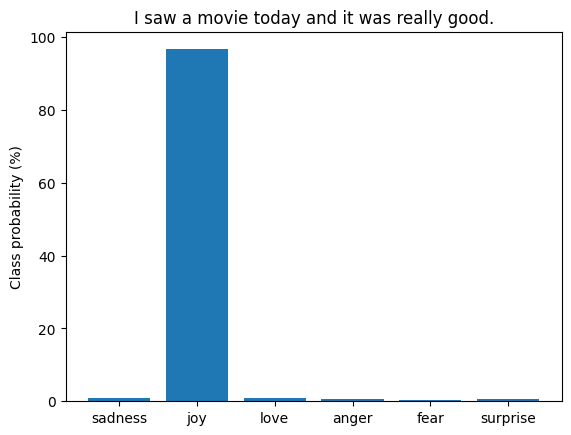

In [71]:
preds_df = pd.DataFrame(preds).sort_values('label').reset_index(drop=True)
plt.bar(labels, 100 * preds_df['score'], color='C0')
plt.title(f"{custom_tweet}")
plt.ylabel("Class probability (%)")
plt.show()